In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime

In [2]:
train_abbr=pd.read_excel("price1_5_train_abbr.xlsx",encoding='ISO-8859-1')
train=pd.read_excel("price1_5_train_complete.xlsx",encoding='ISO-8859-1')
test_abbr=pd.read_excel("price1_6_test_abbr.xlsx",encoding='ISO-8859-1')
test=pd.read_excel("price1_6_test_complete.xlsx",encoding='ISO-8859-1')
test_sub=pd.read_excel("pre1_result.xlsx",encoding='ISO-8859-1')

In [3]:
test.shape

(2496, 12)

In [4]:
test_sub.shape

(0, 0)

In [5]:
train.shape

(3456, 12)

In [6]:
train.head()

,date,time,price1,MW1,MW2,MW3,MW4,MW5,MW6,MW7,pub1,pub2
0,2021-12-01,00:15:00,349.88,58315.6,10231.0,7953.15,0.0,4645,7525,2477.0,35486.45,25484.45
1,2021-12-01,00:30:00,351.36,58164.9,10231.0,7897.84,0.0,4645,7525,2477.0,35391.06,25389.06
2,2021-12-01,00:45:00,351.28,57976.4,10231.0,7851.61,0.0,4645,7525,2477.0,35248.79,25246.79
3,2021-12-01,01:00:00,350.66,57750.4,10231.0,7811.62,0.0,4645,7525,2477.0,35062.78,25060.78
4,2021-12-01,01:15:00,349.86,57448.9,10231.0,7773.40,0.0,4645,7525,2477.0,34799.50,24797.50


In [7]:
train.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3456 entries, 0 to 3455
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3456 non-null   datetime64[ns]
 1   time    3456 non-null   object        
 2   price1  3456 non-null   float64       
 3   MW1     3456 non-null   float64       
 4   MW2     3456 non-null   float64       
 5   MW3     3456 non-null   float64       
 6   MW4     3456 non-null   float64       
 7   MW5     3456 non-null   int64         
 8   MW6     3456 non-null   int64         
 9   MW7     3456 non-null   float64       
 10  pub1    3456 non-null   float64       
 11  pub2    3456 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 324.1+ KB


In [8]:
y_train_=train["price1"]

In [9]:
y_train_.value_counts()

-80.00      222
 440.00      13
 442.00      12
 402.00      12
 450.00      11
 472.00      11
 375.00      10
 448.00      10
 412.00      10
 406.00      10
 418.00      10
 390.00       9
 400.00       9
 275.00       8
 438.00       8
 474.00       8
 370.00       8
 486.00       8
 520.00       8
 414.00       8
 200.00       8
 446.00       8
 338.00       7
 428.00       7
 386.00       7
 151.00       7
 506.00       7
 368.00       7
 500.00       7
 353.00       7
 364.00       7
 277.00       7
 394.00       7
 360.00       7
 460.00       7
 362.00       7
 171.00       6
 456.00       6
 444.00       6
 408.00       6
 267.00       6
 398.00       6
 430.00       6
 198.00       6
 356.00       6
 164.00       6
 175.00       6
 372.00       6
 404.00       6
 273.00       6
 321.00       6
 169.00       6
 191.00       6
 242.00       5
 174.00       5
 182.00       5
 183.00       5
 186.00       5
 458.00       5
 149.00       5
 371.00       5
 462.00       5
 380.00 

In [10]:
y_train_=y_train_.map(lambda x:3 if x==-8 else x)

In [11]:
data=pd.concat([train,test],axis=0,ignore_index=True)

In [12]:
data.shape

(5952, 12)

In [13]:
print(data)

           date      time   price1       MW1       MW2       MW3      MW4  \
0    2021-12-01  00:15:00   349.88  58315.60  10231.00   7953.15     0.00   
1    2021-12-01  00:30:00   351.36  58164.90  10231.00   7897.84     0.00   
2    2021-12-01  00:45:00   351.28  57976.40  10231.00   7851.61     0.00   
3    2021-12-01  01:00:00   350.66  57750.40  10231.00   7811.62     0.00   
4    2021-12-01  01:15:00   349.86  57448.90  10231.00   7773.40     0.00   
5    2021-12-01  01:30:00   349.27  57185.10  10231.00   7740.10     0.00   
6    2021-12-01  01:45:00   348.38  56959.10  10231.00   7705.99     0.00   
7    2021-12-01  02:00:00   348.22  56770.70  10231.00   7682.14     0.00   
8    2021-12-01  02:15:00   348.00  56657.60  10231.00   7678.56     0.00   
9    2021-12-01  02:30:00   347.69  56431.50  10231.00   7676.16     0.00   
10   2021-12-01  02:45:00   346.32  56167.80  10231.00   7675.34     0.00   
11   2021-12-01  03:00:00   346.02  56017.00  10231.00   7673.33     0.00   

In [14]:
data=data.drop(["date"], axis=1)
data=data.drop(["time"], axis=1)
#data=data.drop(["price1"], axis=1)

In [15]:
#data=data.drop(["id"], axis=1)
print(data)

       price1       MW1       MW2       MW3      MW4   MW5   MW6      MW7  \
0      349.88  58315.60  10231.00   7953.15     0.00  4645  7525  2477.00   
1      351.36  58164.90  10231.00   7897.84     0.00  4645  7525  2477.00   
2      351.28  57976.40  10231.00   7851.61     0.00  4645  7525  2477.00   
3      350.66  57750.40  10231.00   7811.62     0.00  4645  7525  2477.00   
4      349.86  57448.90  10231.00   7773.40     0.00  4645  7525  2477.00   
5      349.27  57185.10  10231.00   7740.10     0.00  4645  7525  2477.00   
6      348.38  56959.10  10231.00   7705.99     0.00  4645  7525  2477.00   
7      348.22  56770.70  10231.00   7682.14     0.00  4645  7525  2477.00   
8      348.00  56657.60  10231.00   7678.56     0.00  4645  7525  2477.00   
9      347.69  56431.50  10231.00   7676.16     0.00  4645  7525  2477.00   
10     346.32  56167.80  10231.00   7675.34     0.00  4645  7525  2477.00   
11     346.02  56017.00  10231.00   7673.33     0.00  4645  7525  2477.00   

In [16]:
data["price1"]=data["price1"].map(lambda x:x-1)

In [17]:
X_train_ = data[:train.shape[0]]
X_test_  = data[train.shape[0]:]

In [18]:
target_column = 'price1'
feature_columns=list(X_test_.columns) 
feature_columns

['price1', 'MW1', 'MW2', 'MW3', 'MW4', 'MW5', 'MW6', 'MW7', 'pub1', 'pub2']

In [19]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [20]:
X_train.shape

(3456, 10)

In [21]:
y_train.shape

(3456,)

In [22]:
X_test.shape

(2496, 10)

In [23]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train.astype('int'))

pred = gbdt.predict(X_test)
acc=test['price1']

In [ ]:
print( r2_score(acc, y_pred) )

In [ ]:
#loss='deviance', learning_rate=0.1, n_estimators=5, subsample=1, min_samples_split=2, min_samples_leaf=1,
#max_depth=3, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False

In [30]:
from sklearn.metrics import r2_score, auc
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc=test['price1']
print( r2_score(acc, y_pred) )

0.9996623735803487


In [31]:
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
print ('均方差',mean_squared_error(acc,y_pred))
print ('绝对差',mean_absolute_error(acc,y_pred))
print ('解释度',explained_variance_score(acc,y_pred))

均方差 13.89853566101363
绝对差 1.3176481901968906
解释度 0.9996664469741933


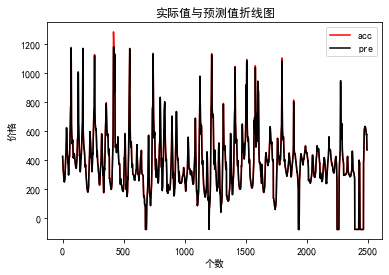

In [32]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
#acc 实际值数据
#y_pred 预测值数据
plt.plot(acc,color="r",label="acc") #颜色表示
plt.plot(y_pred,color=(0,0,0),label="pre") 
plt.xlabel("个数") 
plt.ylabel("价格") 
plt.title("实际值与预测值折线图") 
plt.legend()
plt.show() 

In [ ]:
#有参数设置

In [33]:
##### xgb，'silent': True,

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse',  'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[16:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:423.15982	train-myFeval:179064.25000	valid_data-rmse:430.00470	valid_data-myFeval:184904.06250
[100]	train-rmse:258.60971	train-myFeval:66878.97656	valid_data-rmse:262.86527	valid_data-myFeval:69098.13281
[200]	train-rmse:158.52241	train-myFeval:25129.35742	valid_data-rmse:161.26437	valid_data-myFeval:26006.19922
[300]	train-rmse:97.63002	train-myFeval:9531.62012	valid_data-rmse:99.56554	valid_data-myFeval:9913.29785
[400]	train-rmse:60.27404	train-myFeval:3632.95947	valid_data-rmse:61.76199	valid_data-myFeval:3814.54272
[500]	train-rmse:37.75508	train-myFeval:1425.44629	valid_data-rmse:39.16552	valid_data-myFeval:1533.93835
[600]	train-rmse:24.00100	train-myFeval:576.04810	valid_data-rmse:25.54879	valid_data-myFeval:652.74091
[700]	train-rmse:15.63621	train-myFeval:244.49112	valid_data-r

[8000]	train-rmse:0.58571	train-myFeval:0.34306	valid_data-rmse:3.45884	valid_data-myFeval:11.96354
[8100]	train-rmse:0.57803	train-myFeval:0.33411	valid_data-rmse:3.45643	valid_data-myFeval:11.94694
[8200]	train-rmse:0.57048	train-myFeval:0.32545	valid_data-rmse:3.45363	valid_data-myFeval:11.92759
[8300]	train-rmse:0.56281	train-myFeval:0.31676	valid_data-rmse:3.45132	valid_data-myFeval:11.91161
[8400]	train-rmse:0.55570	train-myFeval:0.30880	valid_data-rmse:3.44919	valid_data-myFeval:11.89692
[8500]	train-rmse:0.54853	train-myFeval:0.30089	valid_data-rmse:3.44674	valid_data-myFeval:11.87999
[8600]	train-rmse:0.54138	train-myFeval:0.29309	valid_data-rmse:3.44391	valid_data-myFeval:11.86053
[8700]	train-rmse:0.53427	train-myFeval:0.28544	valid_data-rmse:3.44107	valid_data-myFeval:11.84098
[8800]	train-rmse:0.52752	train-myFeval:0.27827	valid_data-rmse:3.43878	valid_data-myFeval:11.82523
[8900]	train-rmse:0.52125	train-myFeval:0.27170	valid_data-rmse:3.43672	valid_data-myFeval:11.81105


[16200]	train-rmse:0.23664	train-myFeval:0.05600	valid_data-rmse:3.35952	valid_data-myFeval:11.28637
[16300]	train-rmse:0.23448	train-myFeval:0.05498	valid_data-rmse:3.35896	valid_data-myFeval:11.28263
[16400]	train-rmse:0.23217	train-myFeval:0.05390	valid_data-rmse:3.35838	valid_data-myFeval:11.27875
[16500]	train-rmse:0.23011	train-myFeval:0.05295	valid_data-rmse:3.35772	valid_data-myFeval:11.27426
[16600]	train-rmse:0.22803	train-myFeval:0.05200	valid_data-rmse:3.35737	valid_data-myFeval:11.27196
[16700]	train-rmse:0.22590	train-myFeval:0.05103	valid_data-rmse:3.35695	valid_data-myFeval:11.26913
[16800]	train-rmse:0.22381	train-myFeval:0.05009	valid_data-rmse:3.35637	valid_data-myFeval:11.26524
[16900]	train-rmse:0.22167	train-myFeval:0.04914	valid_data-rmse:3.35598	valid_data-myFeval:11.26260
[17000]	train-rmse:0.21955	train-myFeval:0.04820	valid_data-rmse:3.35545	valid_data-myFeval:11.25907
[17100]	train-rmse:0.21737	train-myFeval:0.04725	valid_data-rmse:3.35517	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°2
[16:25:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:426.09409	train-myFeval:181556.18750	valid_data-rmse:418.27835	valid_data-myFeval:174956.78125
[100]	train-rmse:260.86295	train-myFeval:68049.46094	valid_data-rmse:256.10022	valid_data-myFeval:65587.32031
[200]	train-rmse:160.09570	train-myFeval:25630.63086	valid_data-rmse:157.36253	valid_data-myFeval:24762.96289
[300]	train-rmse:98.49180	train-myFeval:9700.63477	valid_data-rmse:97.22973	valid_data-myFeval:9453.62109
[400]	train-rmse:60.98776	train-myFeval:3719.50708	valid_data-rmse:60.76182	valid_data-myFeval:3691.99854
[500]	train-rmse:38.30251	train-myFeval:1467.08264	valid_data-rmse:38.80947	valid_data-myFeval:1506.17505
[600]	train-rmse:24.59607	train-myFeval:604.96692	valid_data-rmse:25.71091	valid_data-myFeval:661.05090
[700]	train-rmse:16.24942	train-myFeval:264.04364	valid_data-r

[8000]	train-rmse:0.71789	train-myFeval:0.51537	valid_data-rmse:3.95687	valid_data-myFeval:15.65684
[8100]	train-rmse:0.70888	train-myFeval:0.50251	valid_data-rmse:3.95305	valid_data-myFeval:15.62661
[8200]	train-rmse:0.70005	train-myFeval:0.49006	valid_data-rmse:3.94882	valid_data-myFeval:15.59320
[8300]	train-rmse:0.69095	train-myFeval:0.47742	valid_data-rmse:3.94582	valid_data-myFeval:15.56946
[8400]	train-rmse:0.68231	train-myFeval:0.46555	valid_data-rmse:3.94278	valid_data-myFeval:15.54547
[8500]	train-rmse:0.67345	train-myFeval:0.45353	valid_data-rmse:3.93903	valid_data-myFeval:15.51599
[8600]	train-rmse:0.66485	train-myFeval:0.44203	valid_data-rmse:3.93559	valid_data-myFeval:15.48889
[8700]	train-rmse:0.65637	train-myFeval:0.43082	valid_data-rmse:3.93304	valid_data-myFeval:15.46880
[8800]	train-rmse:0.64782	train-myFeval:0.41967	valid_data-rmse:3.93016	valid_data-myFeval:15.44613
[8900]	train-rmse:0.63950	train-myFeval:0.40896	valid_data-rmse:3.92763	valid_data-myFeval:15.42631


[16200]	train-rmse:0.28844	train-myFeval:0.08320	valid_data-rmse:3.81715	valid_data-myFeval:14.57065
[16300]	train-rmse:0.28571	train-myFeval:0.08163	valid_data-rmse:3.81631	valid_data-myFeval:14.56426
[16400]	train-rmse:0.28290	train-myFeval:0.08003	valid_data-rmse:3.81544	valid_data-myFeval:14.55756
[16500]	train-rmse:0.28010	train-myFeval:0.07845	valid_data-rmse:3.81471	valid_data-myFeval:14.55203
[16600]	train-rmse:0.27750	train-myFeval:0.07701	valid_data-rmse:3.81395	valid_data-myFeval:14.54622
[16700]	train-rmse:0.27489	train-myFeval:0.07556	valid_data-rmse:3.81315	valid_data-myFeval:14.54013
[16800]	train-rmse:0.27232	train-myFeval:0.07416	valid_data-rmse:3.81247	valid_data-myFeval:14.53495
[16900]	train-rmse:0.26980	train-myFeval:0.07279	valid_data-rmse:3.81161	valid_data-myFeval:14.52836
[17000]	train-rmse:0.26727	train-myFeval:0.07144	valid_data-rmse:3.81093	valid_data-myFeval:14.52317
[17100]	train-rmse:0.26471	train-myFeval:0.07007	valid_data-rmse:3.81045	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°3
[16:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:425.76364	train-myFeval:181274.71875	valid_data-rmse:419.60739	valid_data-myFeval:176070.37500
[100]	train-rmse:260.69833	train-myFeval:67963.61719	valid_data-rmse:256.73633	valid_data-myFeval:65913.53125
[200]	train-rmse:160.00166	train-myFeval:25600.53906	valid_data-rmse:157.36998	valid_data-myFeval:24765.31445
[300]	train-rmse:98.46716	train-myFeval:9695.78125	valid_data-rmse:96.70904	valid_data-myFeval:9352.63867
[400]	train-rmse:61.00521	train-myFeval:3721.63550	valid_data-rmse:60.06693	valid_data-myFeval:3608.03687
[500]	train-rmse:38.33581	train-myFeval:1469.63403	valid_data-rmse:38.12981	valid_data-myFeval:1453.88220
[600]	train-rmse:24.63689	train-myFeval:606.97620	valid_data-rmse:25.06459	valid_data-myFeval:628.23364
[700]	train-rmse:16.29515	train-myFeval:265.53189	valid_data-r

[8000]	train-rmse:0.68414	train-myFeval:0.46804	valid_data-rmse:3.63553	valid_data-myFeval:13.21709
[8100]	train-rmse:0.67576	train-myFeval:0.45665	valid_data-rmse:3.63251	valid_data-myFeval:13.19511
[8200]	train-rmse:0.66700	train-myFeval:0.44489	valid_data-rmse:3.62905	valid_data-myFeval:13.17000
[8300]	train-rmse:0.65934	train-myFeval:0.43472	valid_data-rmse:3.62655	valid_data-myFeval:13.15187
[8400]	train-rmse:0.65124	train-myFeval:0.42411	valid_data-rmse:3.62426	valid_data-myFeval:13.13525
[8500]	train-rmse:0.64310	train-myFeval:0.41357	valid_data-rmse:3.62147	valid_data-myFeval:13.11504
[8600]	train-rmse:0.63520	train-myFeval:0.40348	valid_data-rmse:3.61863	valid_data-myFeval:13.09450
[8700]	train-rmse:0.62724	train-myFeval:0.39343	valid_data-rmse:3.61608	valid_data-myFeval:13.07602
[8800]	train-rmse:0.61970	train-myFeval:0.38403	valid_data-rmse:3.61374	valid_data-myFeval:13.05908
[8900]	train-rmse:0.61212	train-myFeval:0.37470	valid_data-rmse:3.61081	valid_data-myFeval:13.03797


[16200]	train-rmse:0.28343	train-myFeval:0.08034	valid_data-rmse:3.52319	valid_data-myFeval:12.41284
[16300]	train-rmse:0.28087	train-myFeval:0.07889	valid_data-rmse:3.52233	valid_data-myFeval:12.40685
[16400]	train-rmse:0.27825	train-myFeval:0.07742	valid_data-rmse:3.52181	valid_data-myFeval:12.40315
[16500]	train-rmse:0.27573	train-myFeval:0.07603	valid_data-rmse:3.52116	valid_data-myFeval:12.39860
[16600]	train-rmse:0.27314	train-myFeval:0.07461	valid_data-rmse:3.52060	valid_data-myFeval:12.39461
[16700]	train-rmse:0.27058	train-myFeval:0.07322	valid_data-rmse:3.52003	valid_data-myFeval:12.39061
[16800]	train-rmse:0.26804	train-myFeval:0.07185	valid_data-rmse:3.51930	valid_data-myFeval:12.38545
[16900]	train-rmse:0.26564	train-myFeval:0.07057	valid_data-rmse:3.51882	valid_data-myFeval:12.38213
[17000]	train-rmse:0.26309	train-myFeval:0.06922	valid_data-rmse:3.51804	valid_data-myFeval:12.37662
[17100]	train-rmse:0.26077	train-myFeval:0.06800	valid_data-rmse:3.51756	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°4
[16:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:422.93487	train-myFeval:178873.90625	valid_data-rmse:430.89441	valid_data-myFeval:185669.98438
[100]	train-rmse:258.97601	train-myFeval:67068.57812	valid_data-rmse:264.64258	valid_data-myFeval:70035.67969
[200]	train-rmse:158.96698	train-myFeval:25270.50391	valid_data-rmse:163.07457	valid_data-myFeval:26593.30859
[300]	train-rmse:97.87795	train-myFeval:9580.09473	valid_data-rmse:100.80769	valid_data-myFeval:10162.19043
[400]	train-rmse:60.67555	train-myFeval:3681.52197	valid_data-rmse:62.77632	valid_data-myFeval:3940.86645
[500]	train-rmse:38.13313	train-myFeval:1454.13586	valid_data-rmse:39.73600	valid_data-myFeval:1578.94971
[600]	train-rmse:24.49241	train-myFeval:599.87830	valid_data-rmse:25.92026	valid_data-myFeval:671.86005
[700]	train-rmse:16.16120	train-myFeval:261.18463	valid_data

[8000]	train-rmse:0.67097	train-myFeval:0.45020	valid_data-rmse:3.80823	valid_data-myFeval:14.50262
[8100]	train-rmse:0.66218	train-myFeval:0.43849	valid_data-rmse:3.80490	valid_data-myFeval:14.47724
[8200]	train-rmse:0.65354	train-myFeval:0.42712	valid_data-rmse:3.80248	valid_data-myFeval:14.45882
[8300]	train-rmse:0.64499	train-myFeval:0.41601	valid_data-rmse:3.79990	valid_data-myFeval:14.43927
[8400]	train-rmse:0.63658	train-myFeval:0.40524	valid_data-rmse:3.79742	valid_data-myFeval:14.42038
[8500]	train-rmse:0.62824	train-myFeval:0.39469	valid_data-rmse:3.79459	valid_data-myFeval:14.39889
[8600]	train-rmse:0.62041	train-myFeval:0.38491	valid_data-rmse:3.79265	valid_data-myFeval:14.38421
[8700]	train-rmse:0.61300	train-myFeval:0.37577	valid_data-rmse:3.79044	valid_data-myFeval:14.36744
[8800]	train-rmse:0.60503	train-myFeval:0.36606	valid_data-rmse:3.78804	valid_data-myFeval:14.34924
[8900]	train-rmse:0.59777	train-myFeval:0.35733	valid_data-rmse:3.78636	valid_data-myFeval:14.33651


[16200]	train-rmse:0.27195	train-myFeval:0.07396	valid_data-rmse:3.71739	valid_data-myFeval:13.81898
[16300]	train-rmse:0.26938	train-myFeval:0.07257	valid_data-rmse:3.71707	valid_data-myFeval:13.81660
[16400]	train-rmse:0.26694	train-myFeval:0.07126	valid_data-rmse:3.71672	valid_data-myFeval:13.81402
[16500]	train-rmse:0.26443	train-myFeval:0.06992	valid_data-rmse:3.71631	valid_data-myFeval:13.81096
[16600]	train-rmse:0.26195	train-myFeval:0.06862	valid_data-rmse:3.71592	valid_data-myFeval:13.80808
[16700]	train-rmse:0.25948	train-myFeval:0.06733	valid_data-rmse:3.71550	valid_data-myFeval:13.80495
[16800]	train-rmse:0.25687	train-myFeval:0.06598	valid_data-rmse:3.71502	valid_data-myFeval:13.80137
[16900]	train-rmse:0.25453	train-myFeval:0.06478	valid_data-rmse:3.71470	valid_data-myFeval:13.79903
[17000]	train-rmse:0.25210	train-myFeval:0.06356	valid_data-rmse:3.71440	valid_data-myFeval:13.79676
[17100]	train-rmse:0.24970	train-myFeval:0.06235	valid_data-rmse:3.71392	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


fold n°5
[16:31:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:424.73416	train-myFeval:180399.10938	valid_data-rmse:423.75015	valid_data-myFeval:179564.20312
[100]	train-rmse:260.00879	train-myFeval:67604.57031	valid_data-rmse:259.40683	valid_data-myFeval:67291.89062
[200]	train-rmse:159.58601	train-myFeval:25467.70117	valid_data-rmse:159.47086	valid_data-myFeval:25430.95312
[300]	train-rmse:98.19534	train-myFeval:9642.32324	valid_data-rmse:98.54285	valid_data-myFeval:9710.69141
[400]	train-rmse:60.81249	train-myFeval:3698.15845	valid_data-rmse:61.54547	valid_data-myFeval:3787.84521
[500]	train-rmse:38.18707	train-myFeval:1458.25232	valid_data-rmse:39.19625	valid_data-myFeval:1536.34583
[600]	train-rmse:24.54599	train-myFeval:602.50543	valid_data-rmse:25.82359	valid_data-myFeval:666.85797
[700]	train-rmse:16.25702	train-myFeval:264.29077	valid_data-r

[8000]	train-rmse:0.69563	train-myFeval:0.48390	valid_data-rmse:3.69238	valid_data-myFeval:13.63366
[8100]	train-rmse:0.68663	train-myFeval:0.47146	valid_data-rmse:3.68930	valid_data-myFeval:13.61094
[8200]	train-rmse:0.67764	train-myFeval:0.45920	valid_data-rmse:3.68652	valid_data-myFeval:13.59042
[8300]	train-rmse:0.66953	train-myFeval:0.44828	valid_data-rmse:3.68312	valid_data-myFeval:13.56538
[8400]	train-rmse:0.66123	train-myFeval:0.43722	valid_data-rmse:3.68090	valid_data-myFeval:13.54906
[8500]	train-rmse:0.65299	train-myFeval:0.42640	valid_data-rmse:3.67759	valid_data-myFeval:13.52464
[8600]	train-rmse:0.64473	train-myFeval:0.41568	valid_data-rmse:3.67474	valid_data-myFeval:13.50368
[8700]	train-rmse:0.63673	train-myFeval:0.40542	valid_data-rmse:3.67125	valid_data-myFeval:13.47808
[8800]	train-rmse:0.62878	train-myFeval:0.39537	valid_data-rmse:3.66844	valid_data-myFeval:13.45746
[8900]	train-rmse:0.62076	train-myFeval:0.38535	valid_data-rmse:3.66514	valid_data-myFeval:13.43323


[16200]	train-rmse:0.28043	train-myFeval:0.07864	valid_data-rmse:3.56371	valid_data-myFeval:12.70002
[16300]	train-rmse:0.27772	train-myFeval:0.07713	valid_data-rmse:3.56295	valid_data-myFeval:12.69460
[16400]	train-rmse:0.27509	train-myFeval:0.07567	valid_data-rmse:3.56234	valid_data-myFeval:12.69027
[16500]	train-rmse:0.27248	train-myFeval:0.07424	valid_data-rmse:3.56155	valid_data-myFeval:12.68467
[16600]	train-rmse:0.26996	train-myFeval:0.07288	valid_data-rmse:3.56073	valid_data-myFeval:12.67880
[16700]	train-rmse:0.26747	train-myFeval:0.07154	valid_data-rmse:3.55993	valid_data-myFeval:12.67309
[16800]	train-rmse:0.26483	train-myFeval:0.07013	valid_data-rmse:3.55945	valid_data-myFeval:12.66968
[16900]	train-rmse:0.26235	train-myFeval:0.06883	valid_data-rmse:3.55887	valid_data-myFeval:12.66555
[17000]	train-rmse:0.25997	train-myFeval:0.06759	valid_data-rmse:3.55834	valid_data-myFeval:12.66175
[17100]	train-rmse:0.25766	train-myFeval:0.06639	valid_data-rmse:3.55764	valid_data-myFeval

D:\Application\Anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


CV score: 12.83373821


In [34]:
print( r2_score(acc, predictions_xgb) )

0.9938621248282615


In [35]:
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score
print ('均方差',mean_squared_error(acc,predictions_xgb))
print ('绝对差',mean_absolute_error(acc,predictions_xgb))
print ('解释度',explained_variance_score(acc,predictions_xgb))

均方差 252.66825103720168
绝对差 9.448771147539315
解释度 0.9938753031142563


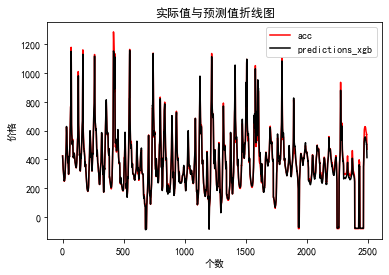

In [37]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
#acc 实际值数据
#predictions_xgb 预测值数据
plt.plot(acc,color="r",label="acc") #颜色表示
plt.plot(predictions_xgb,color=(0,0,0),label="predictions_xgb") 
plt.xlabel("个数") 
plt.ylabel("价格") 
plt.title("实际值与预测值折线图") 
plt.legend()
plt.show() 

In [30]:
##### lgb

param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
   # print(trn_idx)
   # print(".............x_train.........")
   # print(X_train[trn_idx])
  #  print(".............y_train.........")
  #  print(y_train[trn_idx])
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds


D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Application\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	training's l2: 1181.9	valid_1's l2: 1333.93
[400]	training's l2: 88.905	valid_1's l2: 117.609
[600]	training's l2: 35.4143	valid_1's l2: 50.7707
[800]	training's l2: 24.2732	valid_1's l2: 37.3634
[1000]	training's l2: 19.0103	valid_1's l2: 31.6158
[1200]	training's l2: 15.8549	valid_1's l2: 27.9597
[1400]	training's l2: 13.6453	valid_1's l2: 25.7332
[1600]	training's l2: 12.093	valid_1's l2: 24.316
[1800]	training's l2: 10.876	valid_1's l2: 23.2341
[2000]	training's l2: 9.95949	valid_1's l2: 22.5407
[2200]	training's l2: 9.17901	valid_1's l2: 21.8997
[2400]	training's l2: 8.52127	valid_1's l2: 21.3112
[2600]	training's l2: 7.96696	valid_1's l2: 20.9616
[2800]	training's l2: 7.46904	valid_1's l2: 20.7564
[3000]	training's l2: 7.04389	valid_1's l2: 20.4655
[3200]	training's l2: 6.66553	valid_1's l2: 20.3445
[3400]	training's l2: 6.30465	valid_1's l2: 20.1013
[3600]	training's l2: 5.99488	valid_1's l2: 19.9104
[3800]	training's l2: 5.72207	valid_1's l2: 19.7583
[4000]	training's l2:

[200]	training's l2: 1197.53	valid_1's l2: 1245.64
[400]	training's l2: 88.7053	valid_1's l2: 153.673
[600]	training's l2: 36.3334	valid_1's l2: 86.1064
[800]	training's l2: 25.7272	valid_1's l2: 66.4745
[1000]	training's l2: 21.1062	valid_1's l2: 56.8276
[1200]	training's l2: 18.3096	valid_1's l2: 50.2775
[1400]	training's l2: 16.3794	valid_1's l2: 45.6791
[1600]	training's l2: 14.859	valid_1's l2: 42.3169
[1800]	training's l2: 13.6576	valid_1's l2: 39.6879
[2000]	training's l2: 12.6067	valid_1's l2: 37.3354
[2200]	training's l2: 11.6856	valid_1's l2: 35.0957
[2400]	training's l2: 10.8952	valid_1's l2: 33.3859
[2600]	training's l2: 10.2113	valid_1's l2: 31.9944
[2800]	training's l2: 9.59104	valid_1's l2: 30.7562
[3000]	training's l2: 9.02434	valid_1's l2: 29.6529
[3200]	training's l2: 8.54043	valid_1's l2: 28.7199
[3400]	training's l2: 8.09398	valid_1's l2: 27.8693
[3600]	training's l2: 7.68678	valid_1's l2: 27.1198
[3800]	training's l2: 7.29926	valid_1's l2: 26.488
[4000]	training's 

In [28]:
from catboost import Pool, CatBoostRegressor
# cat_features=[0,2,3,10,11,13,15,16,17,18,19]
from sklearn.model_selection import train_test_split


#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_, y_train_, test_size=0.3, random_state=2019)
# train_pool = Pool(X_train_s, y_train_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# val_pool = Pool(X_test_s, y_test_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# test_pool = Pool(X_test_ ,cat_features=[0,2,3,10,11,13,15,16,17,18,19]) 


kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits



print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))


fold n°0
0:	learn: 212.9026007	test: 222.1243941	best: 222.1243941 (0)	total: 143ms	remaining: 3h 58m 44s
100:	learn: 10.4559880	test: 10.1065211	best: 10.1065211 (100)	total: 289ms	remaining: 4m 45s
200:	learn: 6.3247252	test: 6.6135726	best: 6.6135726 (200)	total: 426ms	remaining: 3m 31s
300:	learn: 5.0059354	test: 5.8046675	best: 5.8046675 (300)	total: 555ms	remaining: 3m 3s
400:	learn: 4.3213445	test: 5.3870998	best: 5.3870998 (400)	total: 689ms	remaining: 2m 51s
500:	learn: 3.8926176	test: 5.1627207	best: 5.1581702 (495)	total: 829ms	remaining: 2m 44s
600:	learn: 3.5560025	test: 5.0080355	best: 5.0070591 (599)	total: 994ms	remaining: 2m 44s
700:	learn: 3.2496238	test: 4.8430430	best: 4.8430430 (700)	total: 1.14s	remaining: 2m 40s
800:	learn: 3.0338943	test: 4.7535663	best: 4.7535663 (800)	total: 1.28s	remaining: 2m 38s
900:	learn: 2.8579644	test: 4.7019430	best: 4.7019430 (900)	total: 1.41s	remaining: 2m 35s
1000:	learn: 2.6923901	test: 4.6470096	best: 4.6470096 (1000)	total: 1.55

Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.73722684
bestIteration = 4781

Shrink model to first 4782 iterations.
fold n°3
0:	learn: 215.3534318	test: 210.1855458	best: 210.1855458 (0)	total: 1.64ms	remaining: 2m 44s
100:	learn: 12.2238914	test: 12.6767932	best: 12.6767932 (100)	total: 137ms	remaining: 2m 15s
200:	learn: 7.1613458	test: 7.5150643	best: 7.5150643 (200)	total: 268ms	remaining: 2m 12s
300:	learn: 5.4815139	test: 5.8474747	best: 5.8474747 (300)	total: 394ms	remaining: 2m 10s
400:	learn: 4.6350450	test: 5.0912277	best: 5.0912277 (400)	total: 526ms	remaining: 2m 10s
500:	learn: 4.0889033	test: 4.6681923	best: 4.6681923 (500)	total: 661ms	remaining: 2m 11s
600:	learn: 3.7250808	test: 4.4212717	best: 4.4212717 (600)	total: 791ms	remaining: 2m 10s
700:	learn: 3.4625772	test: 4.2597158	best: 4.2597158 (700)	total: 917ms	remaining: 2m 9s
800:	learn: 3.2599204	test: 4.1499815	best: 4.1492800 (796)	total: 1.06s	remaining: 2m 11s
900:	learn: 3.0948395	test: 4

In [31]:
from sklearn import linear_model
# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train_)))


fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 8.37123119


In [33]:
result=list(predictions)
result=list(map(lambda x: x + 1, result))
test_sub["price2"]=result
test_sub.to_csv("pre2.csv", index=False)

In [32]:
acc=test['price1']

In [33]:
pre_csv=pd.read_csv("pre1.csv",encoding='ISO-8859-1')

In [34]:
pre=pre_csv['price1']

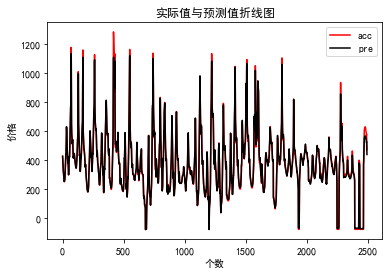

In [35]:
import matplotlib.pyplot as plt  
plt.rcParams['font.sans-serif'] = [u'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
#acc 实际值数据

#pre 预测值数据
 
plt.plot(acc,color="r",label="acc") #颜色表示
 
plt.plot(pre,color=(0,0,0),label="pre") 
 
plt.xlabel("个数") 
 
plt.ylabel("价格") 
 
plt.title("实际值与预测值折线图") 
 
plt.legend()
 
plt.show() 

In [42]:
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score

In [46]:
print ('均方差',mean_squared_error(acc,pre))
print ('绝对差',mean_absolute_error(acc,pre))
print ('解释度',explained_variance_score(acc,pre))

均方差 157.61011368239684
绝对差 7.017872410654368
解释度 0.9961761706186276


In [52]:
y_true = np.array(acc)

In [53]:
y_pred = np.array(pre)

In [54]:
print(y_true)

[426.   404.   380.   ... 547.75 511.88 471.2 ]


In [55]:
print(y_pred)

[425.2326401  404.07822114 379.9859813  ... 502.52178321 472.35871961
 437.49842123]


In [56]:
import math

In [58]:
y_pred1=np.round(y_pred)

In [59]:
print(y_pred1)

[425. 404. 380. ... 503. 472. 437.]


In [64]:
def mape(y_true, y_pred1):
    return np.mean(np.abs((y_pred1-y_true)/y_true))*100

def smape(y_true, y_pred1):
    return 2.0*np.mean(np.abs(y_pred1-y_true)/(np.abs(y_pred1)+np.abs(y_true)))*100


In [65]:
mape1=np.mean(np.abs((425.2326401 - 426) / 426)) * 100
print(mape1)

0.18013143192487652


In [66]:
print(mape(y_true, y_pred))

inf


<ipython-input-64-3032ec563c95>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_pred1-y_true)/y_true))*100
